# Analyzing BiciMad data

Copyright © 2017 Javi Ramírez <javi.rmrz@gmail.com> | [@rameerez [tw]](http://twitter.com/rameerez) | [GitHub](http://github.com/rameerez)

This software is Open Source, released under the MIT License.

_Made with ♥ from Madrid. April, 2017_
 
![EMT Madrid BiciMAD](http://www.imageno.com/image.php?id=h4apsa8ns29m&kk=3486313256)


BiciMad is the public bike system in Madrid, Spain. I'm a big fan of commuting by bike in Madrid (even though car drivers are still complete assholes to bike drivers, and the city is not fully conditioned to bike traffic).

I tend to use my own bike, but still I find myself more than often riding BiciMad bikes (it's pretty convenient: they have an electric motor that assists in pedaling, and you can just take and drop them in the nearest station without having to worry about getting your own bike stolen). Still, every time I've used them, I've detected a number of issues (broken bikes, out-of-order plugs, empty and completely full stations...)

In April 2017 I contacted EMT Madrid (the public company that now runs BiciMad) and asked their OpenData department for BiciMad data to analyze. They inmediatly answered and provided me with a huge dataset and helpful documentation. I want to thank EMT's OpenData for their kindness and contribution.

My goal with this data analysis is to discover hidden patterns that can reveal underlying problems, to provide BiciMad with powerful data-based suggestions that can help improve the service for all us Madrid citizens.

## Dataset description

Please refer to [EMT BiciMad OpenData docs](http://opendata.emtmadrid.es/Servicios-web/BICIMAD) for updated info. This table is only intended for illustration purposes.

| Field name             | Description                                                                                |
|------------------------|--------------------------------------------------------------------------------------------|
| ```_id```              | Travel id                                                                                  |
| ```user_day_code```    | User id. For a single day, all travels made by the same user will have the same user id.   |
| ```idunplug_station``` | **Unplug**: station id.                                                                    |
| ```idunplug_base```    | **Unplug**: base id (base within the station).                                             |
| ```idplug_station```   | **Plug**: station id.                                                                      |
| ```idplug_base```      | **Plug**: base id (base within the station).                                               |
| ```unplug_hourTime```  | Hour at which the travel started, discarding info about minutes and seconds for anonymity. |
| ```travel_time```      | Time in _seconds_ between bike unplug and bike plug back in.                               |
| ```track```            | Travel details in GeoJSON format.                                                          |
| ```user_type```        | 0: undetermined; 1: annual pass; 2: occasional user; 3: BiciMad employee                   |
| ```ageRange```         | 0: undetermined; 1: [0..16]; 2: [17..18]; 3: [19..26]; 4: [27..40]; 5: [41..65] 6: [>66]   |
| ```zip_code```         | User's postal code.                                                                        |

---

## 1. Imports & data loading

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize

In [16]:
# Watch out! lines=True needed
df = pd.read_json('/Users/javi/Downloads/Bicimad_20170301_20170406/export_20170301_20170406.json', lines=True)
df

,_id,ageRange,idplug_base,idplug_station,idunplug_base,idunplug_station,track,travel_time,unplug_hourTime,user_day_code,user_type,zip_code
0,{'$oid': '58d1b3dd865e9c30d0b83c6f'},4,4,17,5,14,NaN,2303,{'$date': '2017-03-01T00:00:00.000+0100'},cc6d426ada96494d8dfe0fe0af512599f439cd9413d50c...,1,28012
1,{'$oid': '58d1b3dc865e9c30d0b83c6c'},4,2,76,22,123,NaN,876,{'$date': '2017-03-01T00:00:00.000+0100'},a81b44c3fe3c2f1e4bf723d228a0d025962228179c2e4d...,1,28009
2,{'$oid': '58d1b3dc865e9c30d0b83c6a'},5,16,163,19,166,NaN,483,{'$date': '2017-03-01T00:00:00.000+0100'},b20f0b657c493842b0aa5ebd32eed5d940c699715ee8bc...,1,28010
3,{'$oid': '58d1b3dd865e9c30d0b83c6e'},4,2,69,18,113,NaN,105,{'$date': '2017-03-01T00:00:00.000+0100'},4da645df4816870214c627aa9b5e6da41098473a9ee111...,1,28045
4,{'$oid': '58d1b3dc865e9c30d0b83c69'},3,16,63,1,10,NaN,327,{'$date': '2017-03-01T00:00:00.000+0100'},521c11677963dcb892b589f0a6f08d1e6060624d410c61...,1,28004
5,{'$oid': '58d1b3dc865e9c30d0b83c6b'},4,14,17,5,4,NaN,480,{'$date': '2017-03-01T00:00:00.000+0100'},425f3fb3c2433f795a50ad702629c6212bd304d543b61f...,3,
6,{'$oid': '58d1b3dd865e9c30d0b83c6d'},4,12,71,3,142,NaN,1034,{'$date': '2017-03-01T00:00:00.000+0100'},bb42e757240175c0e80da446903a51412403d82d4ce397...,1,28020
7,{'$oid': '58d1b3dc865e9c30d0b83c68'},4,19,80,3,74,NaN,263,{'$date': '2017-03-01T00:00:00.000+0100'},03acc26b8494413f2fcfd2087ed616efd16bcdc532c2c9...,1,28023
8,{'$oid': '58d1b3db865e9c30d0b83c67'},5,5,22,21,30,NaN,150,{'$date': '2017-03-01T00:00:00.000+0100'},30db9b39331a505f1b5aaec6ba013fa671081c6c2ac1be...,1,28400
9,{'$oid': '58d1b3db865e9c30d0b83c65'},4,13,129,17,55,NaN,138,{'$date': '2017-03-01T00:00:00.000+0100'},1297e961c792b87667436e29fd7cb95784085675512a9d...,1,28045


## 2. Exploratory analysis
Let's see how our data looks like

In [17]:
df.count()

_id                 289981
ageRange            289981
idplug_base         289981
idplug_station      289981
idunplug_base       289981
idunplug_station    289981
track                87788
travel_time         289981
unplug_hourTime     289981
user_day_code       289981
user_type           289981
zip_code            289981
dtype: int64

We see almost 290.000 bike travels recorded, but only ~87.000 of them contain GPS route information.

### 2.1 Travel times
For how long do usually people use a bike? Are there extreme values? Why?
Do different groups of people use bikes for different time? (for example: do tourists use bikes for longer periods of time?)

First of all, we're gonna need to convert travel times from seconds to minutes to better understand the measurements.

In [72]:
df['travel_time_mins'] = df['travel_time']/60

In [73]:
df['travel_time_mins'].describe()

count    289981.000000
mean         18.274778
std          89.918454
min           0.000000
25%           6.350000
50%          10.650000
75%          16.833333
max        9735.966667
Name: travel_time_mins, dtype: float64

Okay, people usually take bikes for around 18 minutes, which is pretty normal. The standard deviation is very high and there seems to be some extreme values (max=9735min, that's almost 7 days! – probably a stolen/lost bike? It'd be awesome to analyze that GPS track!)

Let's do a log transformation to nullify the effects of extreme values and plot it:

In [76]:
#We need to get rid of zero values first, to avoid divide by zero errors
df_nonzero_travel_times = df.loc[df['travel_time_mins'] > 0]

df['travel_time_mins_log'] = np.log(df_nonzero_travel_times['travel_time_mins'])

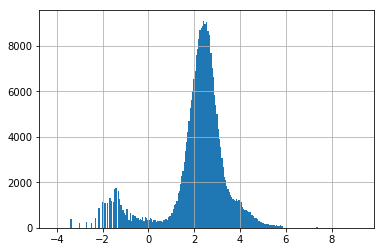

In [77]:
df['travel_time_mins_log'].hist(bins=250)

Okay, let's try to visualize the data to see our outliers. First of all, lets try to plot them all in a boxplot and see the distribution:

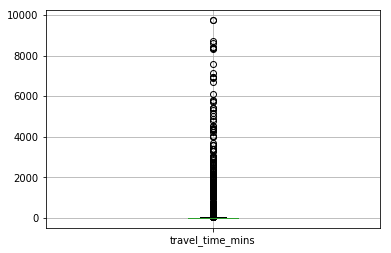

In [101]:
df_non_extreme_travel_times = df.loc[df['travel_time_mins'] > 0]
df_non_extreme_travel_times.boxplot(column='travel_time_mins')

Wow shit, that's some extreme values. Our data is not symmetrical at all. Look at those outliers above 6.000 minutes – that's almost 4 days using a bike! (yup, probably lost or stolen)

In [107]:
df_non_extreme_travel_times = df.loc[df['travel_time_mins'] > 6000]
df_non_extreme_travel_times['travel_time_mins'].count()

15

So there's only 15 bikes that were used for more than 6000 minutes

In [120]:
df_non_extreme_travel_times = df.loc[df['travel_time_mins'] > 360]
df_non_extreme_travel_times['travel_time_mins'].count()

236

And only 236 bikes that were used for more than 360 minutes (6 hours). So, let's remove extreme values and boxplot travels of less than 60 minutes (we're just "loosing" about 5% of the data, which are extreme outliers):

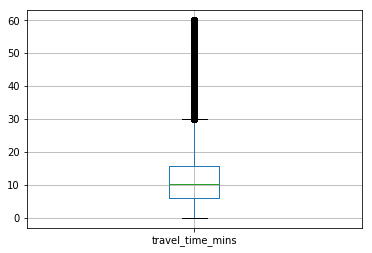

In [122]:
df_non_extreme_travel_times = df.loc[df['travel_time_mins'] < 60]
df_non_extreme_travel_times.boxplot(column='travel_time_mins')

Okay, that's better. Now we can even see the box. As discovered before, most users take a bike for around 5-15 minutes, and we can consider outliers travels of more than 30 minutes. How many outliers are there then and what percentage of the data do they represent?

In [125]:
df_non_extreme_travel_times = df.loc[df['travel_time_mins'] > 30]
df_non_extreme_travel_times['travel_time_mins'].count()

29175

In [128]:
df_non_extreme_travel_times['travel_time_mins'].count() / df['travel_time_mins'].count()

0.10061003996813585

Outliers (travels > 30min): 29175, that's about 10% of the data.

#### Travel times by user type
Do different users behave differently?

Let's recall from the docs:
```
user_type = 0: undetermined
user_type = 1: annual pass holder
user_type = 2: occasional user (incl. tourists, I guess)
user_type = 3: BiciMad employee
```

In [134]:
df.groupby(['user_type'])['travel_time_mins'].describe()

user_type       
0          count      7375.000000
           mean         30.862405
           std          41.412250
           min           0.033333
           25%           7.700000
           50%          15.750000
           75%          37.608333
           max         358.766667
1          count    247605.000000
           mean         14.612580
           std          22.656685
           min           0.000000
           25%           6.666667
           50%          10.416667
           75%          15.466667
           max         359.883333
2          count      3025.000000
           mean         40.599851
           std          44.844825
           min           0.033333
           25%          10.900000
           50%          24.166667
           75%          56.666667
           max         349.983333
3          count     31962.000000
           mean         41.632729
           std         260.885889
           min           0.016667
           25%           0.2500

We see a number of things.

First of all, there's a user_type = 4 that's not documented. Don't know who are those, but they account for more than 3% of the dataset (almost 10k bike travels)

Secondly, there's a **huge** difference between occasional users and regular users. While regular users take bikes for about 15 minutes (with a low std deviation), occasional users use bikes for considerably longer periods: about 40 minutes (and high 44 std dvt). This could mean occasional users are mostly tourists that use bikes for sightseeing and relaxed travels around the city. To be confirmed with GPS data.

Now, look at those BiciMad employee numbers – that's where the outliers come from! It was not stolen/lost bikes, it was probably bikes under maintenance!


On with our next question: do users with different age behave in different ways?

In [135]:
df.groupby(['user_type', 'ageRange'])['travel_time_mins'].describe()

user_type  ageRange       
0          0         count     7375.000000
                     mean        30.862405
                     std         41.412250
                     min          0.033333
                     25%          7.700000
                     50%         15.750000
                     75%         37.608333
                     max        358.766667
1          0         count     2325.000000
                     mean        20.198050
                     std         32.583063
                     min          0.033333
                     25%          7.333333
                     50%         12.200000
                     75%         19.800000
                     max        357.916667
           1         count     2262.000000
                     mean        15.109859
                     std         22.537625
                     min          0.033333
                     25%          5.504167
                     50%          9.616667
                     75%   

#### Popular hours

#### Popular hours by station per day

---

## Most popular stations
Which are the most popular stations? Which are mainly used for taking bikes and which are mainly used to return bikes? Are there any popular travels between 2 stations?

In [12]:
df['idunplug_station'].value_counts()

43      4217
57      4085
129     3869
163     3809
64      3705
135     3513
90      3272
108     3127
168     3037
160     2968
162     2951
45      2924
132     2875
149     2787
83      2756
58      2751
161     2740
49      2739
9       2714
128     2712
23      2668
1       2582
79      2563
78      2454
170     2446
38      2432
74      2420
113     2333
59      2314
166     2284
        ... 
21      1025
159     1004
152      990
151      987
101      977
165      962
105      953
111      945
141      929
104      906
36       898
61       896
138      876
144      869
107      861
98       858
22       857
97       854
147      837
120      759
24       714
173      693
88       649
37       633
150      625
29       615
60       531
28       505
119      436
2008      37
Name: idunplug_station, dtype: int64

In [14]:
df['idplug_station'].value_counts()

43      4386
57      4044
129     3943
163     3898
135     3721
64      3696
90      3260
168     3154
108     3062
160     3060
162     3027
45      3000
132     2986
49      2794
83      2780
161     2768
9       2763
149     2762
58      2753
128     2724
23      2638
1       2543
79      2502
78      2481
170     2449
74      2423
38      2418
133     2360
59      2316
166     2298
        ... 
165     1008
127      996
159      992
151      969
101      946
152      943
105      906
104      892
36       892
141      886
61       881
111      875
138      853
107      853
98       850
22       849
97       848
147      847
144      830
120      781
24       697
173      692
88       627
150      607
37       607
29       590
60       524
28       470
119      425
2008      38
Name: idplug_station, dtype: int64

### GPS tracks analysis

In [163]:
# Lets filter our DataFrame and get a DataFrame only with entries containing a not-NaN "track" property
df_track = df.loc[df.track.notnull()]

Unfortunately, the GeoJSON stored by BiciMad is not in a valid GeoJSON format :(

 - Single quotes `(')` should be double quotes `(")`
 - A `FeatureCollection` GeoJSON should be of this form:
    ```
    { "type": "FeatureCollection",
      "features": [
      .
      .
      .
     ]}
    ```
    Instead of:
    ```
    {'FeatureCollection': 
        {'Features': [
        ]}
    }
    ```
 - The `features` property should be lowercase
    
Useful links:
 - [GeoJSON specification (RFC7946)](https://tools.ietf.org/html/rfc7946)
 - [Online GeoJSON linter, validator & viewer](http://geojsonlint.com)
 

In [164]:
df_track

,_id,ageRange,idplug_base,idplug_station,idunplug_base,idunplug_station,track,travel_time,unplug_hourTime,user_day_code,user_type,zip_code,travel_time_log,travel_time_mins,travel_time_mins_log
115348,{'$oid': '58d18956865e9c3790a34a04'},4,21,60,10,19,{'FeatureCollection': {'Features': [{'properti...,156725,{'$date': '2017-03-13T12:00:00.000+0100'},fce2be1e9634cbcf37fc6898d12d0dff8732ac0b159f07...,3,,11.962248,2612.083333,7.867903
117252,{'$oid': '58d1a814865e9c1d0415cd52'},1,2,71,15,132,{'FeatureCollection': {'Features': [{'properti...,261831,{'$date': '2017-03-13T16:00:00.000+0100'},ba8ccf63ccc66fc4c28adc621bcc15a3a70286ab3a2480...,3,,12.475455,4363.850000,8.381110
129814,{'$oid': '58d181be865e9c3790a32858'},5,7,36,2,36,{'FeatureCollection': {'Features': [{'properti...,18887,{'$date': '2017-03-14T20:00:00.000+0100'},1c15cc8e667946f44f0a07aaaf529d3737527d04f1c6b4...,1,28009,9.846229,314.783333,5.751885
130571,{'$oid': '58d181be865e9c3790a32857'},4,22,13,22,13,{'FeatureCollection': {'Features': [{'properti...,12680,{'$date': '2017-03-14T21:00:00.000+0100'},33287e1807327a243dc12ee4d297ef8f56940992257c63...,1,28005,9.447781,211.333333,5.353437
130574,{'$oid': '58d181e8865e9c3790a32901'},4,5,49,10,40,{'FeatureCollection': {'Features': [{'properti...,18043,{'$date': '2017-03-14T21:00:00.000+0100'},ea67a1693aabf82860de4c3eda49ea95dd0939e17b3d21...,1,28047,9.800513,300.716667,5.706169
131154,{'$oid': '58d181f0865e9c3790a32925'},3,10,121,4,149,{'FeatureCollection': {'Features': [{'properti...,15125,{'$date': '2017-03-14T22:00:00.000+0100'},0e203142eb42fa7178db31ec80aba50695d3408c2872ba...,1,28008,9.624104,252.083333,5.529760
131156,{'$oid': '58d181f5865e9c3790a3293c'},4,9,160,9,19,{'FeatureCollection': {'Features': [{'properti...,17864,{'$date': '2017-03-14T22:00:00.000+0100'},8ad7e45dc1603c71cd29397bec6fd0cbe785d3de791ff7...,1,28004,9.790543,297.733333,5.696198
131500,{'$oid': '58d181c3865e9c3790a3286b'},4,20,1,11,77,{'FeatureCollection': {'Features': [{'properti...,6859,{'$date': '2017-03-14T23:00:00.000+0100'},3ec89a8148c0b835cace234fcc38ddd3a2561d1068a3f4...,3,,8.833317,114.316667,4.738972
131813,{'$oid': '58d181b7865e9c3790a3283c'},4,24,29,23,149,{'FeatureCollection': {'Features': [{'properti...,1853,{'$date': '2017-03-15T00:00:00.000+0100'},2a192bd4ccebe687f6af157215a528f0c549f0e603455b...,1,28005,7.524561,30.883333,3.430217
131814,{'$oid': '58d181b8865e9c3790a32841'},3,15,137,4,43,{'FeatureCollection': {'Features': [{'properti...,1690,{'$date': '2017-03-15T00:00:00.000+0100'},5e0c3f0a0ccc690c35de9056c24afc44e0f7702cb0c8f4...,1,28026,7.432484,28.166667,3.338139


In [168]:
df_track.loc[df_track['travel_time_mins'] > 3000]

,_id,ageRange,idplug_base,idplug_station,idunplug_base,idunplug_station,track,travel_time,unplug_hourTime,user_day_code,user_type,zip_code,travel_time_log,travel_time_mins,travel_time_mins_log
117252,{'$oid': '58d1a814865e9c1d0415cd52'},1,2,71,15,132,{'FeatureCollection': {'Features': [{'properti...,261831,{'$date': '2017-03-13T16:00:00.000+0100'},ba8ccf63ccc66fc4c28adc621bcc15a3a70286ab3a2480...,3,,12.475455,4363.850000,8.381110
132725,{'$oid': '58d6f6a5865e9c36b475effb'},4,1,2008,5,79,{'FeatureCollection': {'Features': [{'properti...,522803,{'$date': '2017-03-15T08:00:00.000+0100'},cb1821c93016b118cd051bbad7235e6ee02917c9e9802a...,3,,13.166960,8713.383333,9.072615
143097,{'$oid': '58d5a52d865e9c338c190ee7'},4,16,133,5,67,{'FeatureCollection': {'Features': [{'properti...,402740,{'$date': '2017-03-16T00:00:00.000+0100'},519360a2fb67b71612bd724597fa771b521de1faea0915...,3,,12.906046,6712.333333,8.811702
145025,{'$oid': '58d6f69c865e9c36b475ebd0'},4,5,79,5,82,{'FeatureCollection': {'Features': [{'properti...,427285,{'$date': '2017-03-16T09:00:00.000+0100'},73eadbfecc7348c8a1d2b9e7e381ca0dfee3bd32c57d76...,3,,12.965207,7121.416667,8.870862
147075,{'$oid': '58d45390865e9c36145751eb'},4,12,145,16,95,{'FeatureCollection': {'Features': [{'properti...,242053,{'$date': '2017-03-16T13:00:00.000+0100'},3bb1f648a0044033ce5666387c9d23e4b5663a83ccebc7...,3,,12.396912,4034.216667,8.302567
148394,{'$oid': '58db519c865e9c19b8b3dffd'},4,9,83,19,132,{'FeatureCollection': {'Features': [{'properti...,584055,{'$date': '2017-03-16T14:00:00.000+0100'},7cd44a7b5dabf6cd73e56eb263da528c0ea2721ff0baea...,3,,13.277750,9734.250000,9.183406
155449,{'$oid': '58d5a52e865e9c338c190f35'},5,5,159,18,135,{'FeatureCollection': {'Features': [{'properti...,301008,{'$date': '2017-03-17T04:00:00.000+0100'},3d9162dd9783d1b8a027cea65d47887696a1e139f90bb0...,3,,12.614892,5016.800000,8.520548
155603,{'$oid': '58d45390865e9c36145751db'},4,17,145,5,151,{'FeatureCollection': {'Features': [{'properti...,180223,{'$date': '2017-03-17T06:00:00.000+0100'},7db26f4863f2c61236260121339f0e3395948f6d1789f0...,3,,12.101950,3003.716667,8.007606
158907,{'$oid': '58db519a865e9c19b8b3df72'},4,8,79,8,112,{'FeatureCollection': {'Features': [{'properti...,500632,{'$date': '2017-03-17T13:00:00.000+0100'},1357ad462bc16d867d887476b5653aa2e02e9e42aa3c3c...,3,,13.123627,8343.866667,9.029282
158909,{'$oid': '58db519c865e9c19b8b3dffb'},4,10,83,1,111,{'FeatureCollection': {'Features': [{'properti...,501398,{'$date': '2017-03-17T13:00:00.000+0100'},1357ad462bc16d867d887476b5653aa2e02e9e42aa3c3c...,3,,13.125155,8356.633333,9.030811


In [171]:
df_track['track'][117252]

{'FeatureCollection': {'Features': [{'geometry': {'coordinates': [-3.6932255,
      40.4108902997222],
     'type': 'Point'},
    'properties': {'secondsfromstart': 45398,
     'speed': 0,
     'var': '28014,ES,Madrid,Madrid,CALLE ALMADEN,Madrid'},
    'type': 'Feature'},
   {'geometry': {'coordinates': [-3.693267, 40.4111015], 'type': 'Point'},
    'properties': {'secondsfromstart': 41794,
     'speed': 0,
     'var': '28014,ES,Madrid,Madrid,CALLE CENICERO 7,Madrid'},
    'type': 'Feature'},
   {'geometry': {'coordinates': [-3.6930383, 40.411025799722196],
     'type': 'Point'},
    'properties': {'secondsfromstart': 38189,
     'speed': 0,
     'var': '28014,ES,Madrid,Madrid,PASEO PRADO 36,Madrid'},
    'type': 'Feature'},
   {'geometry': {'coordinates': [-3.69576679972222, 40.4105871],
     'type': 'Point'},
    'properties': {'secondsfromstart': 16561,
     'speed': 1.05,
     'var': '28012,ES,Madrid,Madrid,CALLE MARQUES DE TOCA 96,Madrid'},
    'type': 'Feature'},
   {'geometry': 

## 3. Explanatory analysis

After having a preliminary view at the data and getting familiar with it, we'll try to answer the following questions:
 - Where are the users mostly travelling from?
 - Where are the users mostly travelling to?

## 4. Machine learning & predictions
Can we train a model to predict bike failures? Can we detect different clusters of users with different behaviors?